In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import griddata

In [31]:
# Parameters
N = 4               # one flux quanta through the sites size 
B = 2 * 3.14159/N       # Magnetic field
a = 1                   # Lattice constant
t = 1                   # Hopping parameter         
D = 10                  # No of such cells in a unitcell of nanoribbon

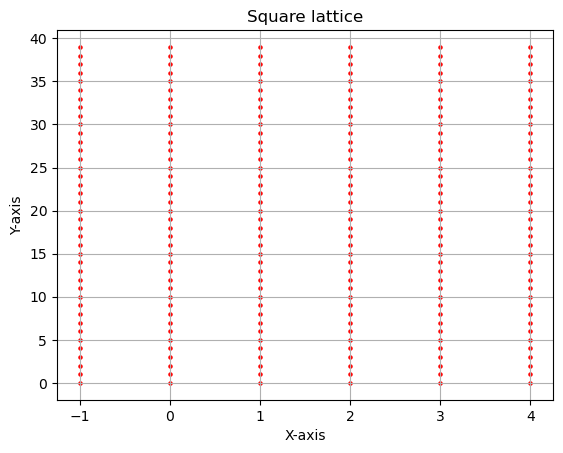

In [32]:
# Defining the Base lattice  - (SQUARE LATICE)
# lattice translation vectors
A1 = [1, 0]
A2 = [0, 1]


# Lattice generation and visualization
sqX_x = []
sqX_y = []
for col in range(0, (D*N)):
    for row in range(-1, N+1):
        sqX_x.append((A1[0] * row) + (A2[0] * col))
        sqX_y.append((A1[1] * row) + (A2[1] * col))
# Plot the points
g = plt.figure();
plt.scatter(sqX_x, sqX_y, color='red', s=5)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Square lattice')
plt.grid(True)
plt.show()

160


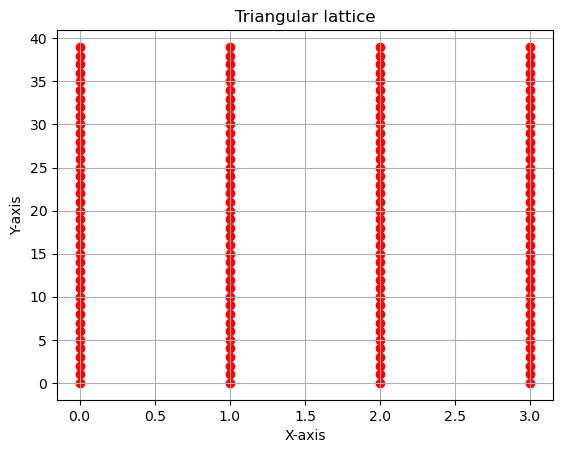

In [33]:
# unit cell of the nano-ribbon
unitcell_x = []
unitcell_y = []
# Bounds of unit cell
Xlow =  - 0.5
Xhigh = 3.5
Ylow =  - 0.5
Yhigh = (D*N) + 0.5
for i in range(len(sqX_x)):
    [x, y] = [sqX_x[i], sqX_y[i]]
    if x >= Xlow and x < Xhigh and y >= Ylow and y < Yhigh:
        unitcell_x.append(x)  
        unitcell_y.append(y)

#print(unitcell_x)
print(len(unitcell_y))

g = plt.figure();
plt.scatter(unitcell_x, unitcell_y, color='red')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Triangular lattice')
plt.grid(True)
plt.show()

In [34]:
# neighbour table formation
# translation vector
Tx = [N, 0]
D1 = [1, 0]
D2 = [-1, 0]
D3 = [0, 1]
D4 = [0, -1]
NN1 = []
NN2 = []
NN3 = []
NN4 = []

def neig_1(i, j):
    [x, y] = [unitcell_x[i], unitcell_y[i]]
    [x1, y1] = [unitcell_x[j], unitcell_y[j]]
    # NN1 
    if np.allclose([x1, y1],[x + D1[0] , y + D1[1]]):
        NN1.append(j)
    elif np.allclose([x1, y1], [x + D1[0] - Tx[0], y + D1[1] - Tx[1]]):
        NN1.append(j)
    return 

def neig_2(i, j):
    [x, y] = [unitcell_x[i], unitcell_y[i]]
    [x1, y1] = [unitcell_x[j], unitcell_y[j]]
    # NN1 
    if np.allclose([x1, y1],[x + D2[0] , y + D2[1]]):
        NN2.append(j)
    elif np.allclose([x1, y1], [x + D2[0] + Tx[0], y + D2[1] + Tx[1]]):
        NN2.append(j)
    return 

def neig_3(i, j):
    [x, y] = [unitcell_x[i], unitcell_y[i]]
    [x1, y1] = [unitcell_x[j], unitcell_y[j]]
    # NN1 
    if np.allclose([x1, y1],[x + D3[0] , y + D3[1]]):
        NN3.append(j)
    elif np.allclose([x1, y1],[x + D3[0] , y + D3[1] - (N*D) ]):
        NN3.append(None)
    return 

def neig_4(i, j):
    [x, y] = [unitcell_x[i], unitcell_y[i]]
    [x1, y1] = [unitcell_x[j], unitcell_y[j]]
    # NN1 
    if np.allclose([x1, y1],[x + D4[0] , y + D4[1]]):
        NN4.append(j)
    elif np.allclose([x1, y1],[x + D4[0] , y + D4[1] + (N*D) ]):
        NN4.append(None)
    return 

for i in tqdm(range(len(unitcell_x))):
    for j in range(len(unitcell_x)):
        neig_1(i, j)
        neig_2(i, j)
        neig_3(i, j)
        neig_4(i, j)

#print(NN1)
#print(NN2)
#print(NN3)
#print(NN4)

100%|██████████| 160/160 [00:04<00:00, 33.81it/s]


In [38]:
# y index for implementing periodicity in applied field
ind = [i for i in range(N)]
xdir_ind = []
for i in range(D):
    for j in range(N):
        for k in range(N):
            xdir_ind.append(ind[j])
ydir_ind = [ind[i % N] for i in range(D*N*N)]
#print(xdir_ind)

In [43]:
" Defining the Hamiltonian Matrix "
def H(kx):
    k = [kx, 0]
    Hij = np.zeros((len(unitcell_x), len(unitcell_x)), dtype=np.complex128)
    for i in range(0,len(unitcell_x)):
        n1, n2 = int(NN1[i]), int(NN2[i])  # Convert to integers
        Hij[i][i] = 0
        Hij[n1][i] = t * np.exp(np.dot(k, D1)) * np.exp(-1j * B * (xdir_ind[i]+1)/2)
        Hij[n2][i] = t * np.exp(np.dot(k, D2)) * np.exp(1j * B * (xdir_ind[i]+1)/2)
    for i in range(len(unitcell_x)): 
        n3, n4 = NN3[i], NN4[i] 
        if n3 is not None : 
            n3 = int(n3)
            Hij[n3][i] = t * np.exp(1j * B * (ydir_ind[i]+1)/2)
        if n4 is not None :
            n4 = int(n4)
            Hij[n4][i] = t * np.exp(-1j * B * (ydir_ind[i]+1)/2)
    return Hij      

In [44]:
BZ = np.linspace(-(np.pi)/N, (np.pi)/N, 100)

band = np.zeros((len(unitcell_x), len(BZ)))
for i in tqdm(range(0, len(BZ))):
    eigen = np.linalg.eigvalsh(H(BZ[i]))
    for b_index in range(0, len(unitcell_x)):
        band[b_index][i] = eigen[b_index]


100%|██████████| 100/100 [00:01<00:00, 77.13it/s]


(-0.7853981633974483, 0.7853981633974483)

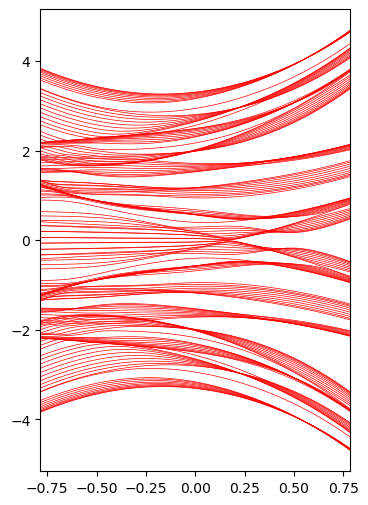

In [45]:
f = plt.figure(figsize=(4,6));   
for b_index in range(0, len(unitcell_x)):
    plt.plot( BZ, band[b_index], c = 'red', linestyle='-', linewidth = 0.5 )
#plt.ylim(-3.6, -0.75)
plt.xlim(BZ[0], BZ[-1])